In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from math import floor, ceil
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

## Constants

### Puncuation

In [2]:
PUNCUATION = ['!', '"', "'", '(', ')', ',', '.', ':', ';','?', '¡', '¿', '\\']

## Summary

### Head

In [3]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [4]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


### Description

In [5]:
train_logs.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.999]).round(0)

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0
mean,2068.0,793560.0,793658.0,98.0,1223.0,231.0
std,1588.0,514945.0,514943.0,253.0,949.0,176.0
min,1.0,106.0,252.0,0.0,0.0,0.0
1%,35.0,47863.0,47964.0,0.0,9.0,2.0
5%,171.0,109978.0,110076.0,12.0,87.0,18.0
25%,852.0,373184.0,373282.0,66.0,499.0,96.0
50%,1726.0,720886.0,720980.0,93.0,1043.0,200.0
75%,2926.0,1163042.0,1163141.0,122.0,1706.0,327.0
95%,5121.0,1664020.0,1664111.0,176.0,3037.0,565.0


### Unique Activity

In [6]:
print(np.unique(train_logs.activity))

['Input' 'Move From [0, 158] To [234, 392]'
 'Move From [0, 1] To [590, 591]' 'Move From [0, 75] To [1, 76]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1061, 1126] To [1306, 1371]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1144, 1147] To [1142, 1145]' 'Move From [13, 65] To [9, 61]'
 'Move From [1306, 1371] To [1061, 1126]'
 'Move From [134, 169] To [122, 157]'
 'Move From [1361, 1362] To [1358, 1359]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [140, 272] To [299, 431]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [164, 165] To [153, 154]'
 'Move From [1651, 1769] To [1565, 1683]'
 'Move From [1766, 1968] To [1861, 2063]'
 'Move From [186, 187] To [184, 185]'
 'Move From [1861, 2063] To [1766, 1968]'
 'Move From [2091, 2179] To [252, 340]'
 'Move From [213, 302] To [902, 991]' 'Move From [218, 220] To [206, 208]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [274, 314] To [299, 339]' 'Move From [284, 292] To [282, 290]'
 'Move From [287,

### Unique Down Event

In [7]:
print(np.unique(train_logs.down_event))

['!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2'
 '5' ':' ';' '<' '=' '>' '?' '@' 'A' 'Alt' 'AltGraph' 'ArrowDown'
 'ArrowLeft' 'ArrowRight' 'ArrowUp' 'AudioVolumeDown' 'AudioVolumeMute'
 'AudioVolumeUp' 'Backspace' 'C' 'Cancel' 'CapsLock' 'Clear' 'ContextMenu'
 'Control' 'Dead' 'Delete' 'End' 'Enter' 'Escape' 'F' 'F1' 'F10' 'F11'
 'F12' 'F15' 'F2' 'F3' 'F6' 'Home' 'I' 'Insert' 'Leftclick' 'M'
 'MediaPlayPause' 'MediaTrackNext' 'MediaTrackPrevious' 'Meta'
 'Middleclick' 'ModeChange' 'NumLock' 'OS' 'PageDown' 'PageUp' 'Pause'
 'Process' 'Rightclick' 'S' 'ScrollLock' 'Shift' 'Space' 'T' 'Tab'
 'Unidentified' 'Unknownclick' 'V' '[' '\\' ']' '^' '_' '`' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v'
 'w' 'x' 'y' 'z' '{' '|' '}' '~' '\x80' '\x96' '\x97' '\x9b' '¡' '¿' 'Â´'
 'Ä±' 'Å\x9f' 'Ë\x86' 'â\x80\x93' 'ä']


### Unique Text Change

In [8]:
for x in np.unique(train_logs.text_change):
    print(x)











































    qq qqqqqqqqqqqq qq qqqqqqq q qqqqqqâq qqqqqqqq qqq qqqq qqqqqqqqqqq qqqqqqqqqq qqqqqqqqqqq qqqqq qqq qqqqq.

    q qqqqqqqq qq qqqqqqq q qqqqq qqqqqqqqq qq qqq qqqqqâq qqqqqq qq qqqq qqqqq.

    qqqqqqq qqq qqqqqqqq qq qqqqqqq qqqq qqqqqqqq qqqqq qq qqqqqqqq qqqqq, qqqqqqqq qq qqqqqqqqqqq.

    qqqqqqqqqqqqqqqq qqq qqqqqqqqq qq qqqqqqqqqqq qqqqqqqqqqq qqqq qq qqqqqqq qqqq qqqqqqqq qqq qqqq qq-qqqqqq qqqq qqqqqqqq qq qqqqqqqq qqqq.

    q qqqqqqqqqq qq qqqq qq qqqq qqqqqqqq qqq qqqq qqqqqqqqq.



  => 

qqqqqqqq qqqq qqqqqq qqq qqqqqqqqq, qqqqqqqqqqq qqq qqqqqqqqqqq qqq qqqq qqqqqqqqq qqqqqqq qq q qqqqqq qqqqqqqqq.  qqqqq qqq qqq qqqq qqqqq qqqqqqq, qqqqqqqqq qqqqq qqqqqqqqqqq qqq/qq qqqqqqqqqqq qq qqqqqqqqqqq, qqq qq qq qqqqqqqqqqq, qqq, qqq qqqq qqqq qqqqqqqqq, qqqq qqqqqqqqq qqqqqqq qq qqqqqqqq, qqqq qq qqqqqqq qq qqqqqqqqqq.  qqqqqqqqqqq qqq qqqq qqqqqqqqqqqq qq qqqqqqqqqqq qqq qqqqqqqqqqq qq qqq qqqqqq qqqq qqqqq qq qqqqqq qqqqqq.  

### Score Distribution

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
[  5  35  69  92 201 336 486 501 402 179 128  37]
[0.99797653 0.98583569 0.97207608 0.96276811 0.91865641 0.86402266
 0.80331849 0.79724808 0.83731283 0.92755969 0.94819911 0.98502631]


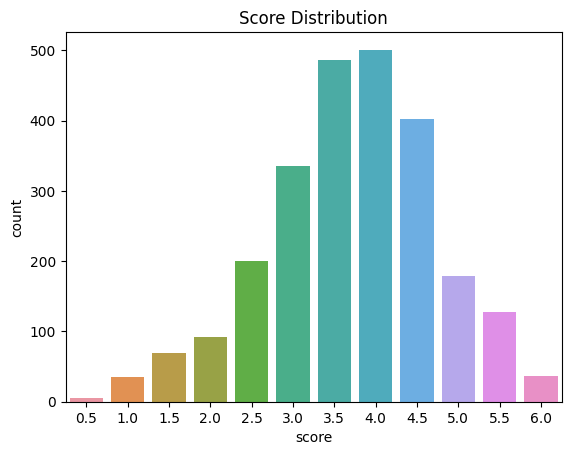

In [9]:
stats_label, stats_count = np.unique(train_scores.score, return_counts=True)
print(stats_label)
print(stats_count)
print(1 - (stats_count / 2471))
catplot = sns.barplot(x=train_scores.score.value_counts().index, y=train_scores.score.value_counts())
plt.title("Score Distribution")
plt.show()

## Feature Analysis

### Word Count

#### Max

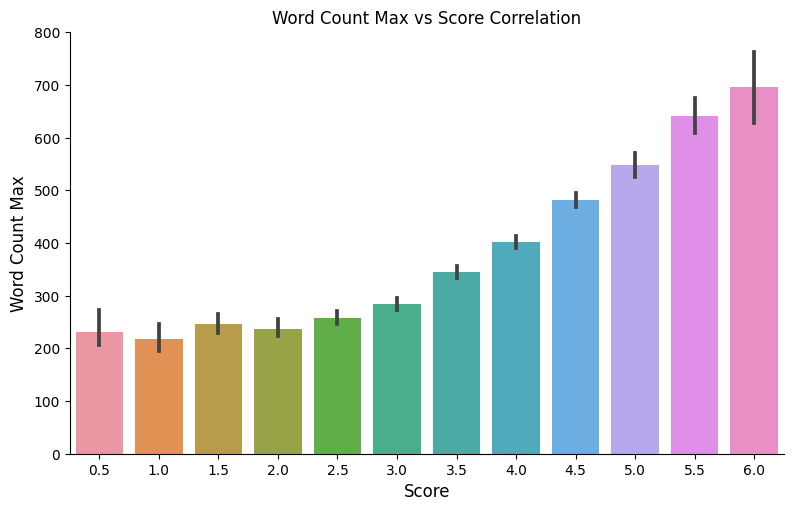

In [10]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count Max', fontsize=12)
plt.title("Word Count Max vs Score Correlation")
plt.show()

In [11]:
stats.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
1%,199.7
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Mean

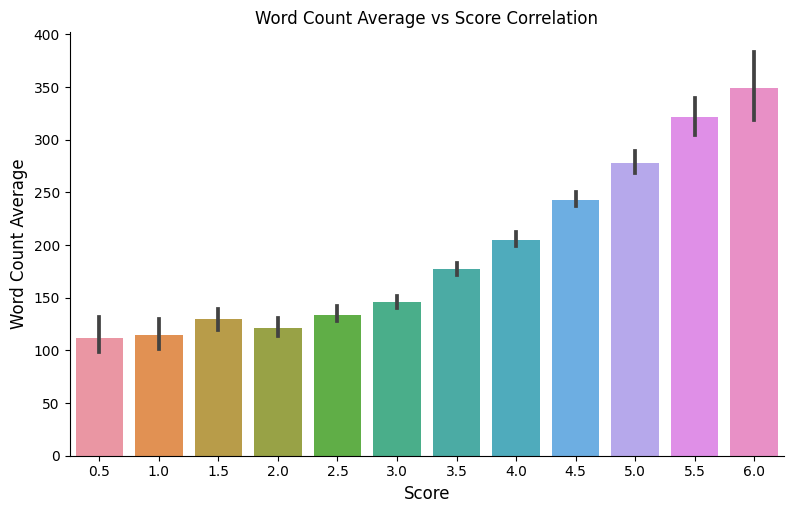

In [12]:
stats = train_logs.groupby("id")["word_count"].mean().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count Average', fontsize=12)
plt.title("Word Count Average vs Score Correlation")
plt.show()

#### Standard Deviation

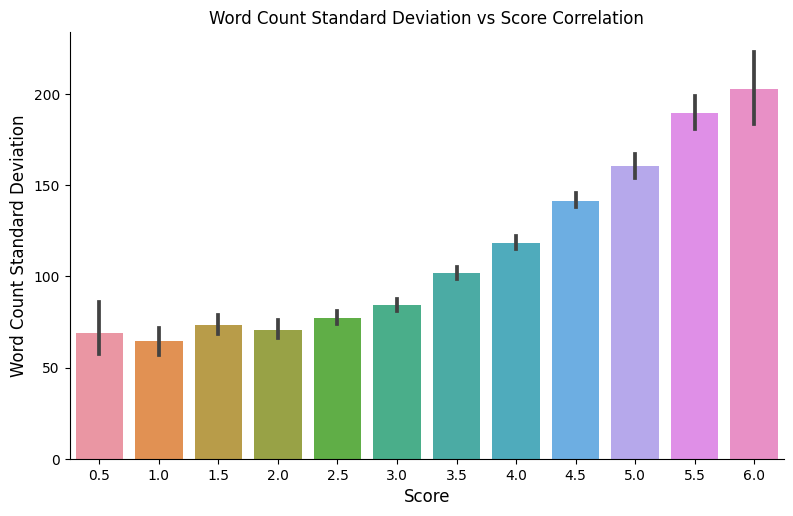

In [13]:
stats = train_logs.groupby("id")["word_count"].std().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count Standard Deviation', fontsize=12)
plt.title("Word Count Standard Deviation vs Score Correlation")
plt.show()

#### Standard Error

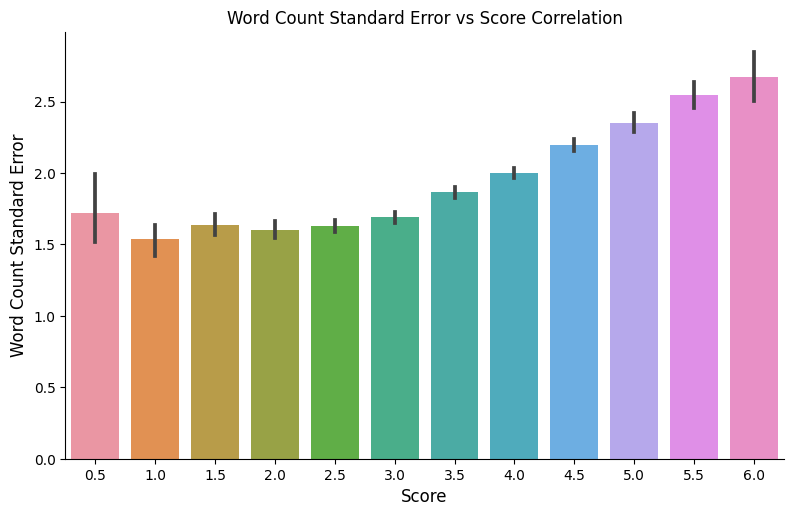

In [14]:
stats = train_logs.groupby("id")["word_count"].sem().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count Standard Error', fontsize=12)
plt.title("Word Count Standard Error vs Score Correlation")
plt.show()

### Event Count

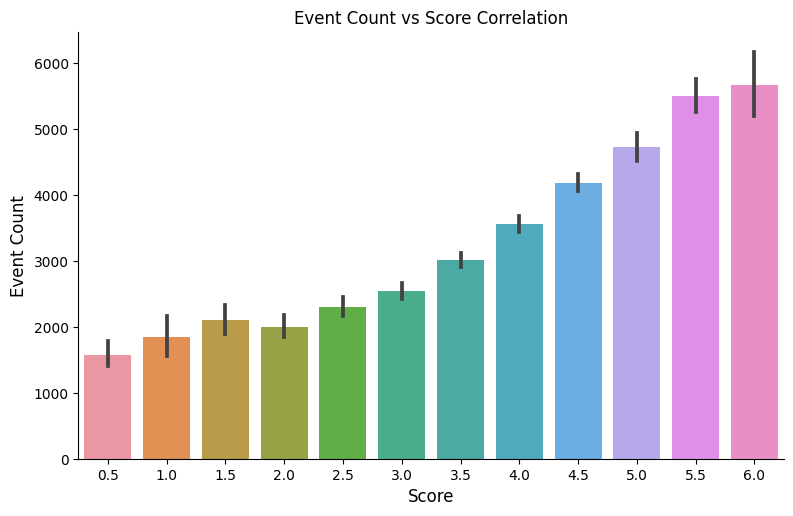

In [15]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [16]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


### Activity Count vs Score

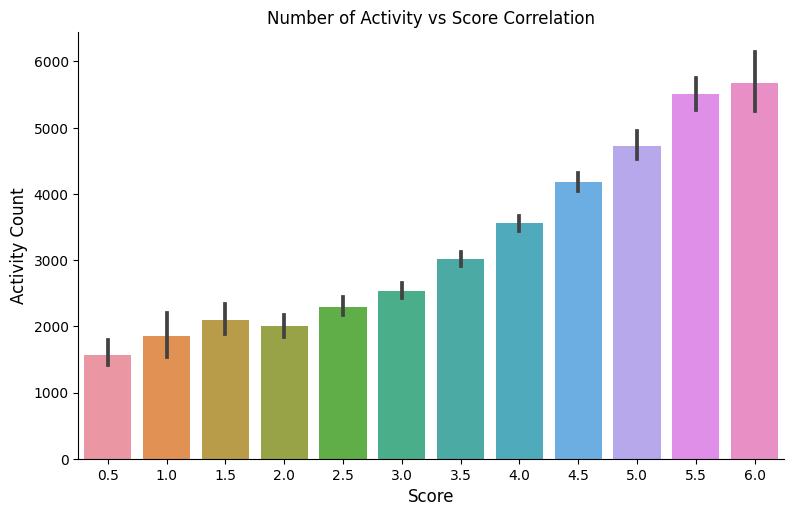

In [17]:
stats = train_logs.groupby("id")["activity"].count().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="activity", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)
plt.title("Number of Activity vs Score Correlation")
plt.show()

            id  score  count
0     001519c8    3.5      3
1     0022f953    3.5      0
2     0042269b    6.0      0
3     0059420b    2.0      0
4     0075873a    4.0      0
...        ...    ...    ...
2466  ffb8c745    3.5      0
2467  ffbef7e5    4.0      0
2468  ffccd6fd    1.5      0
2469  ffec5b38    5.0      0
2470  fff05981    4.0      1

[2471 rows x 3 columns]


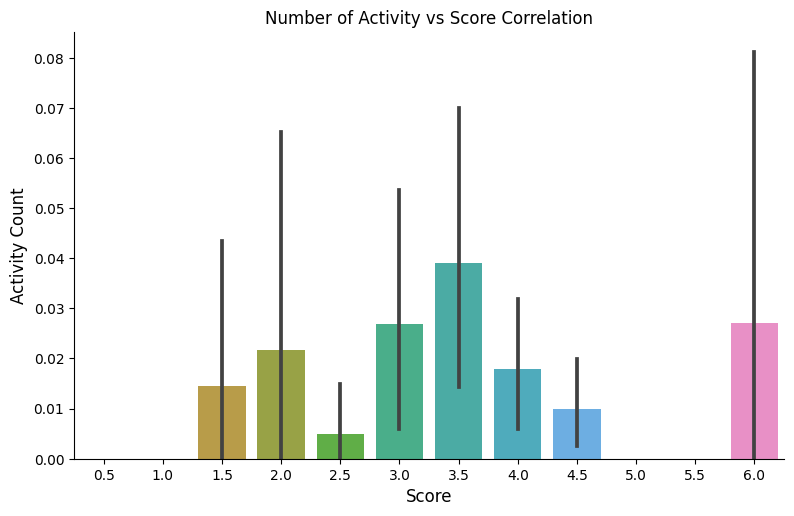

In [18]:
stats = train_logs.copy(deep=True)
stats["count"] = list(map(lambda x: x.count("Move From"), stats['activity']))
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')
print(stats_score)
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)
plt.title("Number of Activity vs Score Correlation")
plt.show()

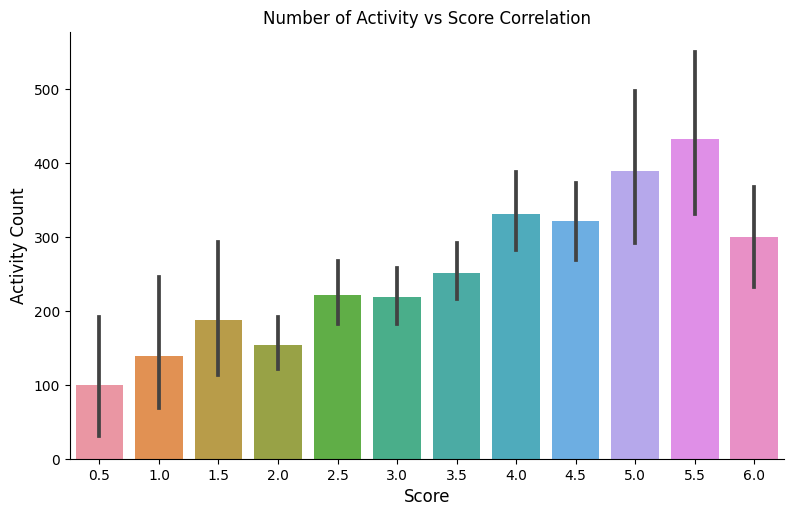

In [19]:
stats = train_logs[train_logs["activity"] == "Nonproduction"].groupby("id").count().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="activity", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)
plt.title("Number of Activity vs Score Correlation")
plt.show()

### Down Time

#### Average

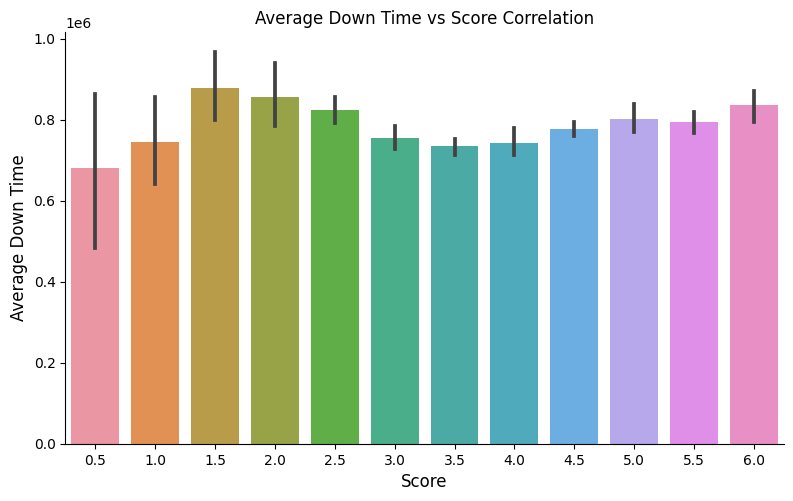

In [20]:
stats = train_logs.groupby("id")["down_time"].mean().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Average Down Time', fontsize=12)
plt.title("Average Down Time vs Score Correlation")
plt.show()

#### First Down Time

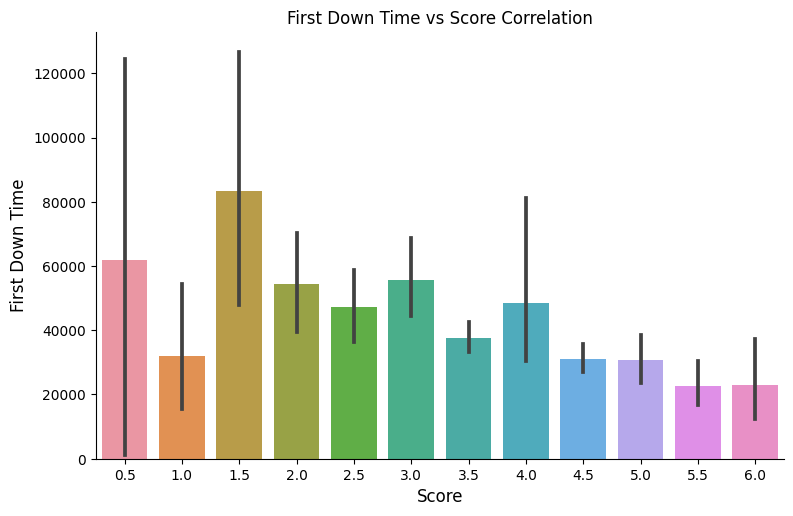

In [21]:
stats = train_logs.groupby("id")["down_time"].min().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('First Down Time', fontsize=12)
plt.title("First Down Time vs Score Correlation")
plt.show()

#### Sum

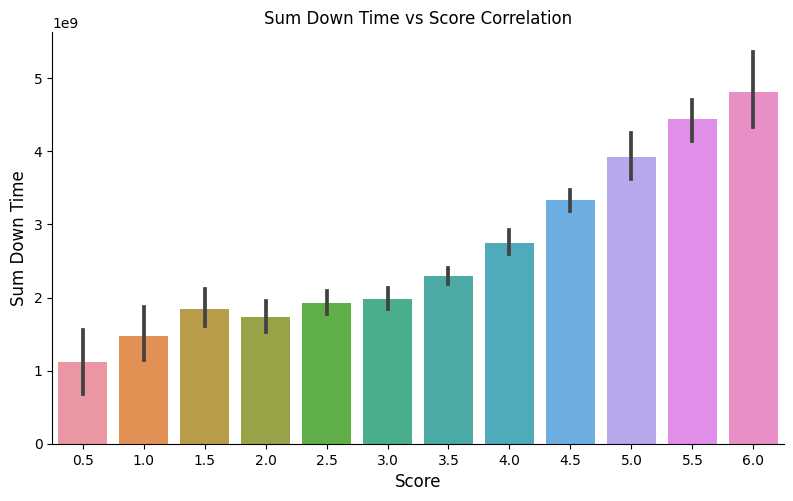

In [22]:
stats = train_logs.groupby("id")["down_time"].sum().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Sum Down Time', fontsize=12)
plt.title("Sum Down Time vs Score Correlation")
plt.show()

#### Skew

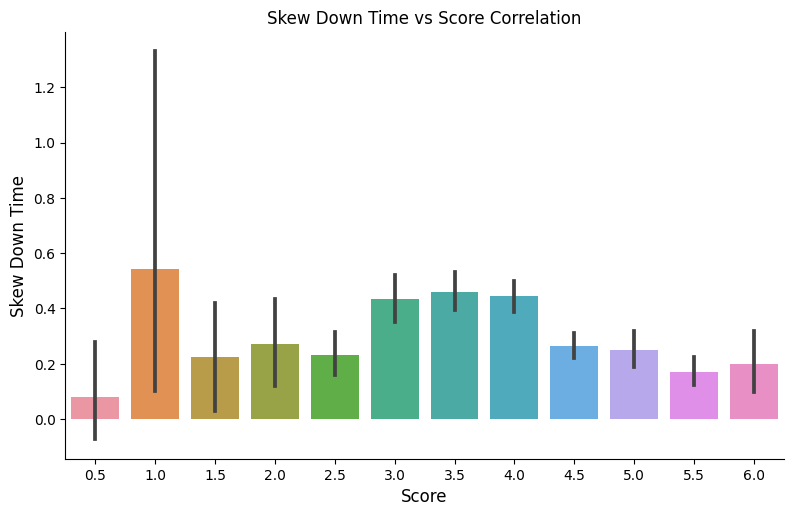

In [23]:
stats = train_logs.groupby("id")["down_time"].skew().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Skew Down Time', fontsize=12)
plt.title("Skew Down Time vs Score Correlation")
plt.show()

#### Standard Deviation

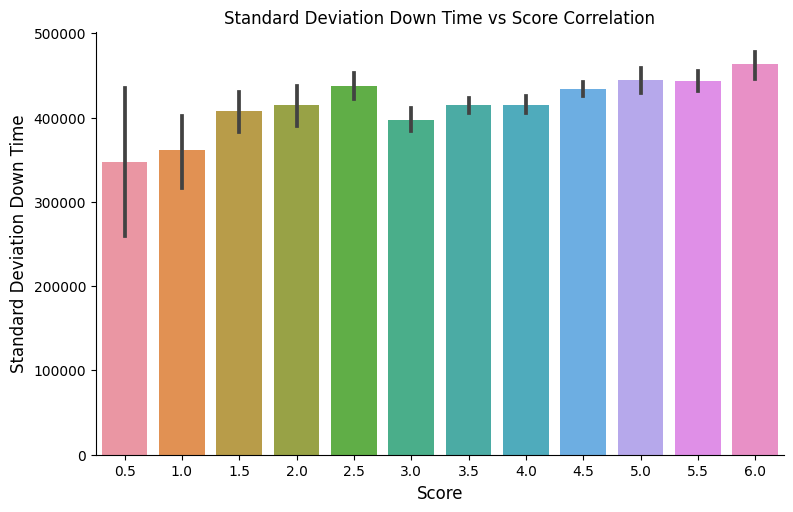

In [24]:
stats = train_logs.groupby("id")["down_time"].std().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Standard Deviation Down Time', fontsize=12)
plt.title("Standard Deviation Down Time vs Score Correlation")
plt.show()

#### Standard Error

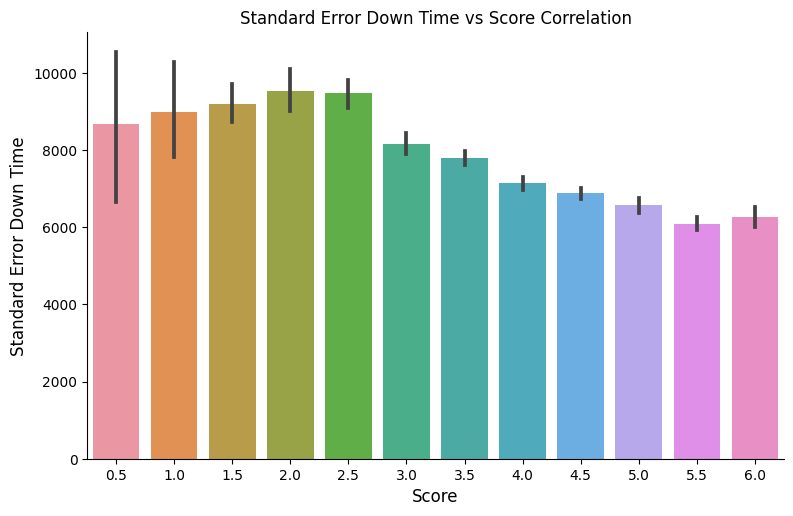

In [25]:
stats = train_logs.groupby("id")["down_time"].sem().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Standard Error Down Time', fontsize=12)
plt.title("Standard Error Down Time vs Score Correlation")
plt.show()

#### Down Time Gaps

            id  event_id
0     001519c8       225
1     0022f953       155
2     0042269b       166
3     0059420b       248
4     0075873a       138
...        ...       ...
2466  ffb8c745       113
2467  ffbef7e5       173
2468  ffccd6fd       221
2469  ffec5b38       137
2470  fff05981       287

[2471 rows x 2 columns]


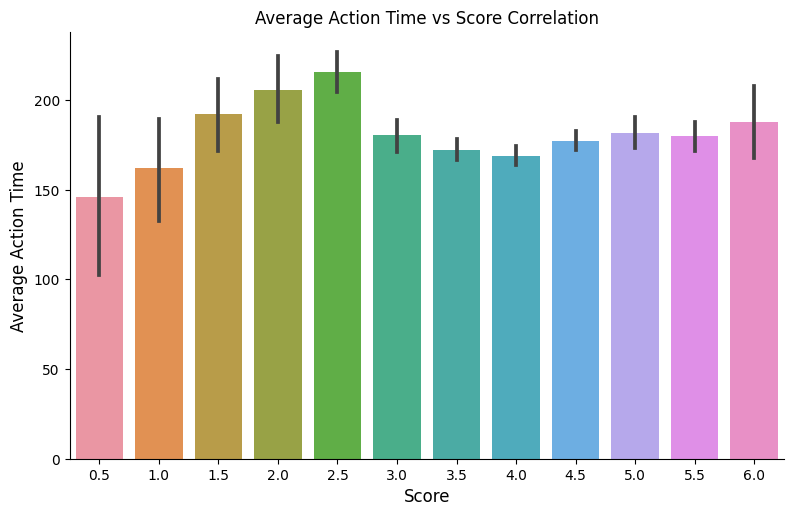

In [26]:
stats = train_logs[train_logs.groupby("id")["down_time"].diff(periods=1, axis=0) > 1000].dropna().groupby("id")["event_id"].count().reset_index()
print(stats)
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Average Action Time', fontsize=12)
plt.title("Average Action Time vs Score Correlation")
plt.show()

del stats
del stats_score

### Action Time

#### Average

In [27]:
train_logs.action_time.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(1)

count    8405898.0
mean          98.1
std          253.4
min            0.0
1%             0.0
5%            12.0
25%           66.0
50%           93.0
75%          122.0
95%          176.0
99%          245.0
max       447470.0
Name: action_time, dtype: float64

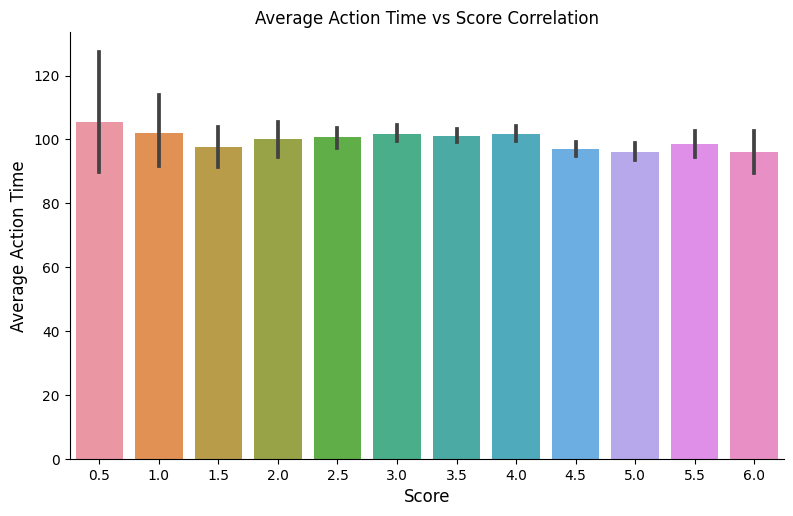

In [28]:
stats = train_logs.groupby("id")["action_time"].mean().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Average Action Time', fontsize=12)
plt.title("Average Action Time vs Score Correlation")
plt.show()

#### Sum

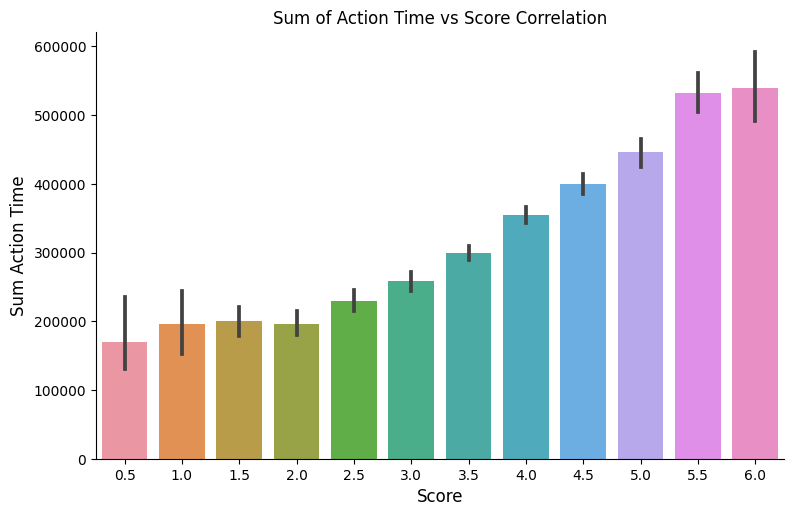

In [29]:
stats = train_logs.groupby("id")["action_time"].sum().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Sum Action Time', fontsize=12)
plt.title("Sum of Action Time vs Score Correlation")
plt.show()

#### Standard Deviation

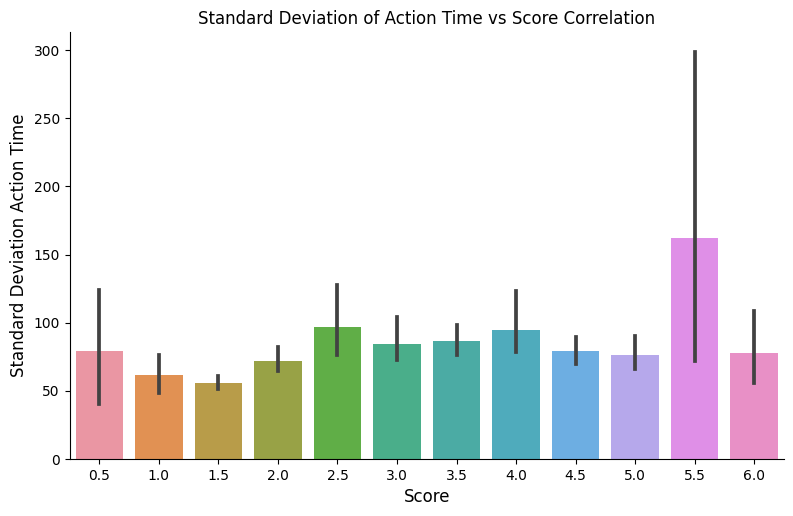

In [30]:
stats = train_logs.groupby("id")["action_time"].std().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Standard Deviation Action Time', fontsize=12)
plt.title("Standard Deviation of Action Time vs Score Correlation")
plt.show()

#### Standard Error

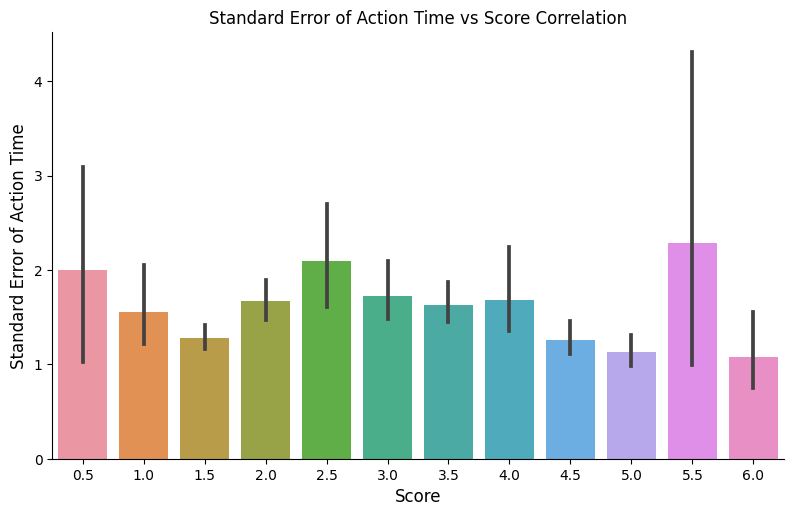

In [31]:
stats = train_logs.groupby("id")["action_time"].sem().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Standard Error of Action Time', fontsize=12)
plt.title("Standard Error of Action Time vs Score Correlation")
plt.show()

#### Skew

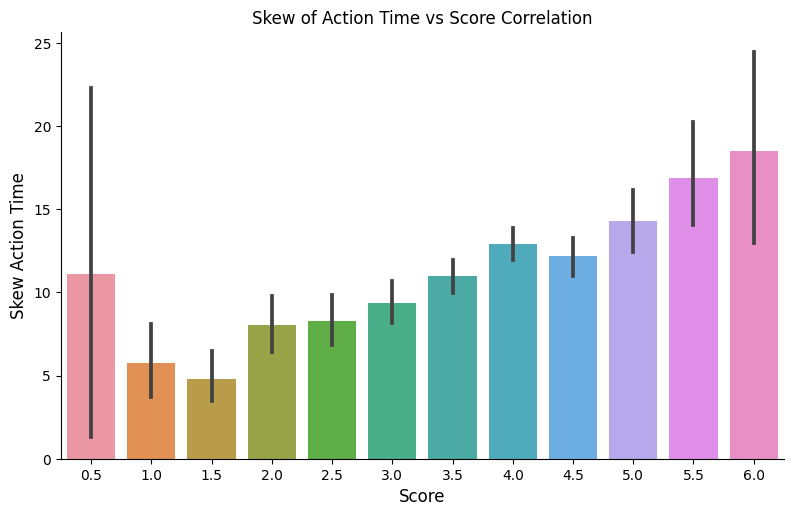

In [32]:
stats = train_logs.groupby("id")["action_time"].skew().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Skew Action Time', fontsize=12)
plt.title("Skew of Action Time vs Score Correlation")
plt.show()

#### Time Spikes

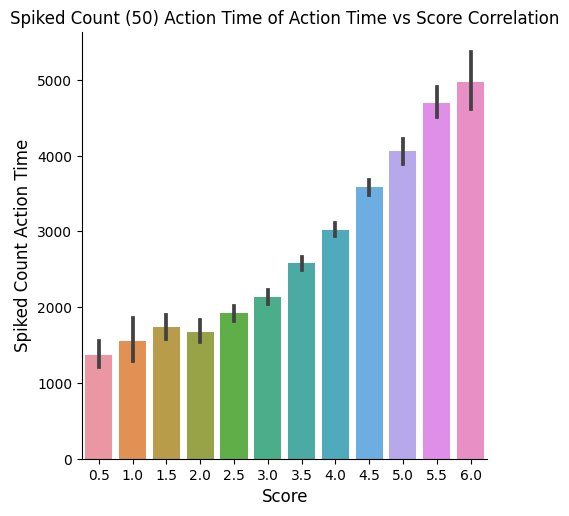

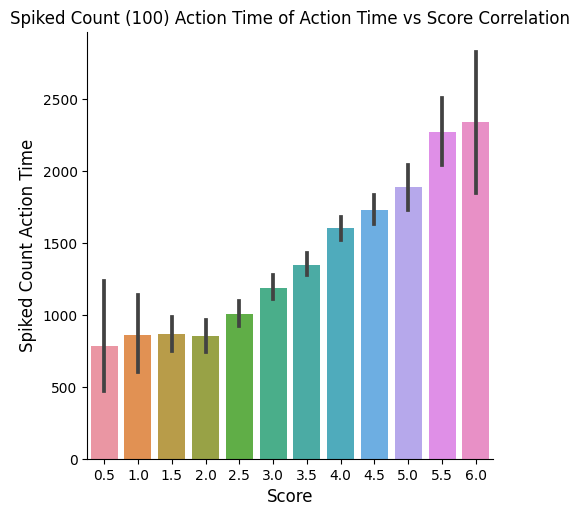

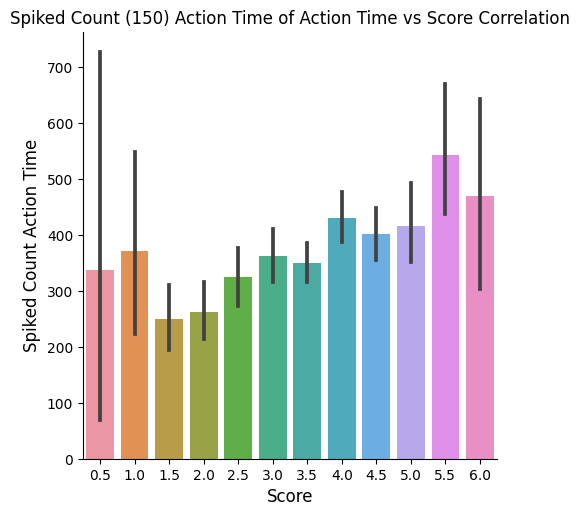

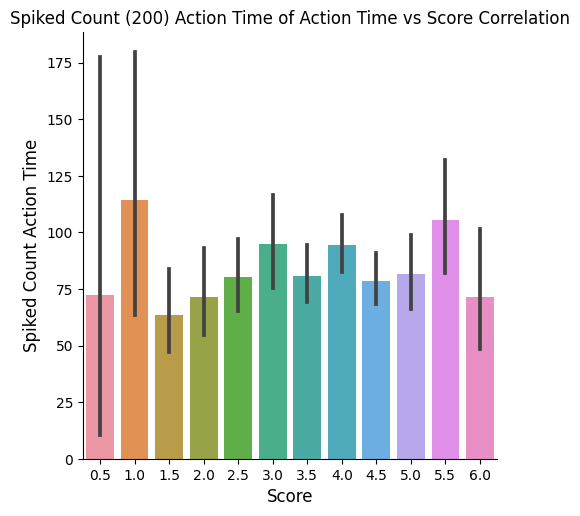

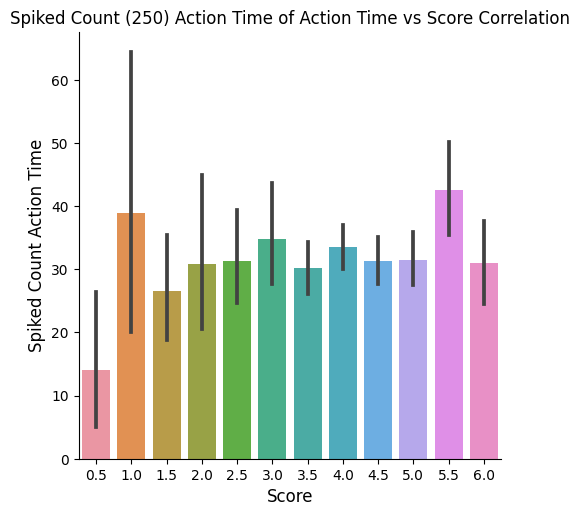

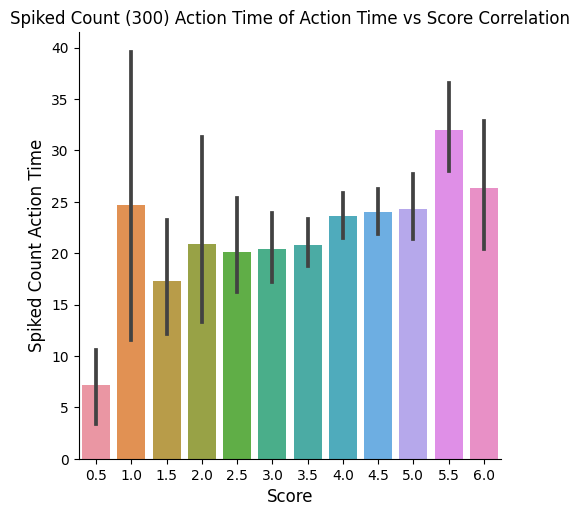

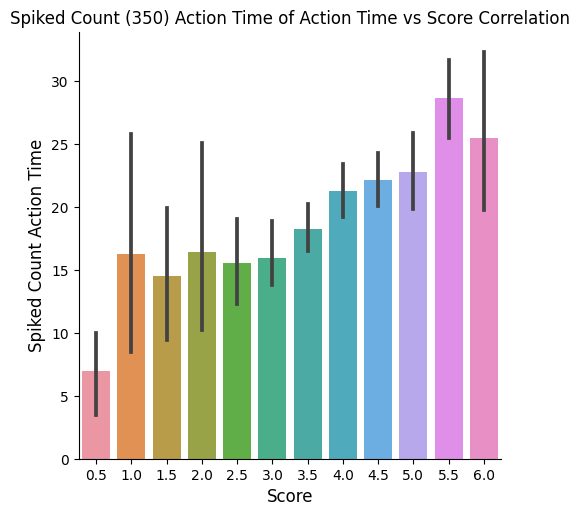

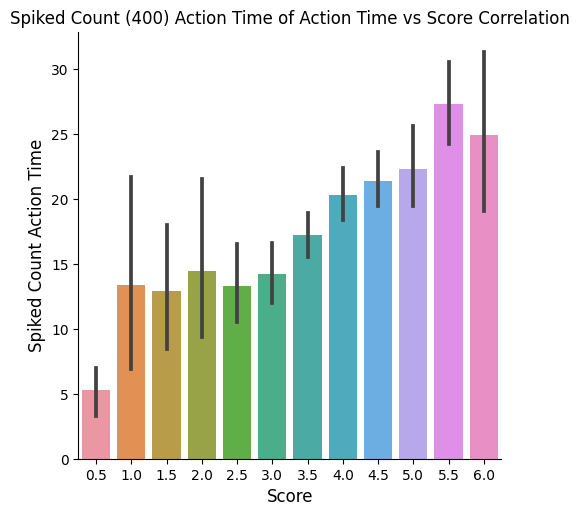

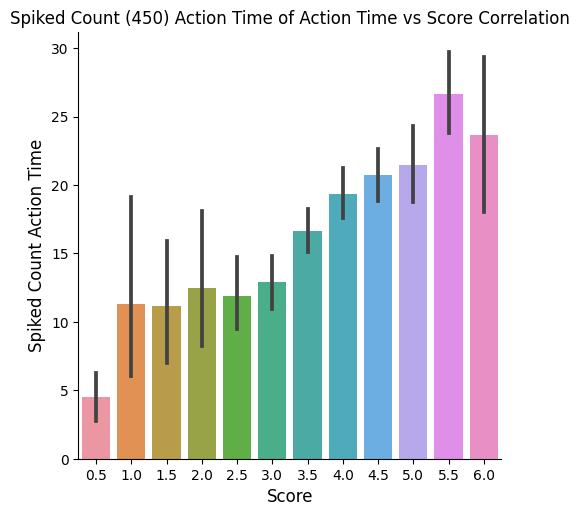

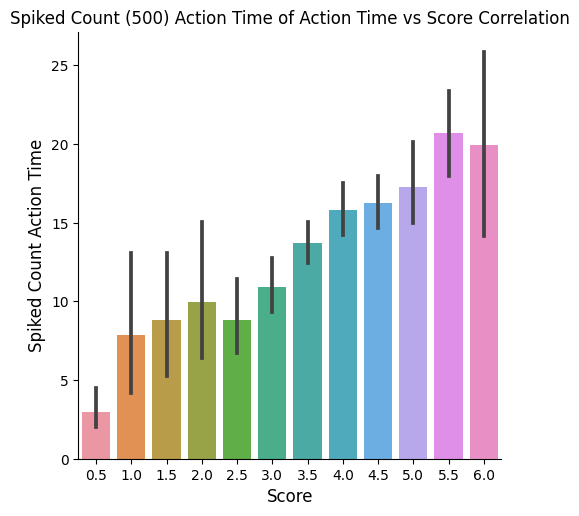

In [33]:
for i in range(1, 11, 1):
    stats = train_logs[train_logs["action_time"] >= i*50].groupby("id").action_time.count().reset_index()
    stats_score = stats.merge(train_scores, on='id')

    sns.catplot(data=stats_score, x="score", y="action_time", kind="bar")
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('Spiked Count Action Time', fontsize=12)
    plt.title(f"Spiked Count ({i*50}) Action Time of Action Time vs Score Correlation")

plt.show()

### Inputs vs Score

#### All Inputs

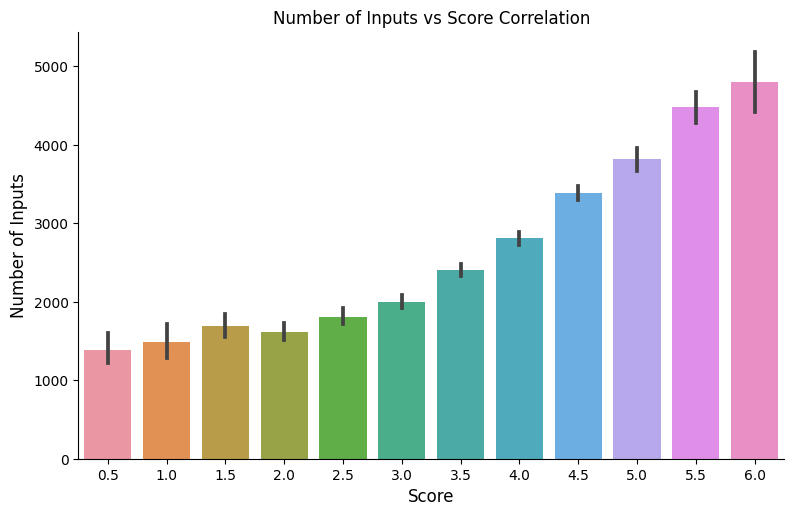

In [34]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Input"].reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Inputs', fontsize=12)
plt.title("Number of Inputs vs Score Correlation")
plt.show()

#### Removals

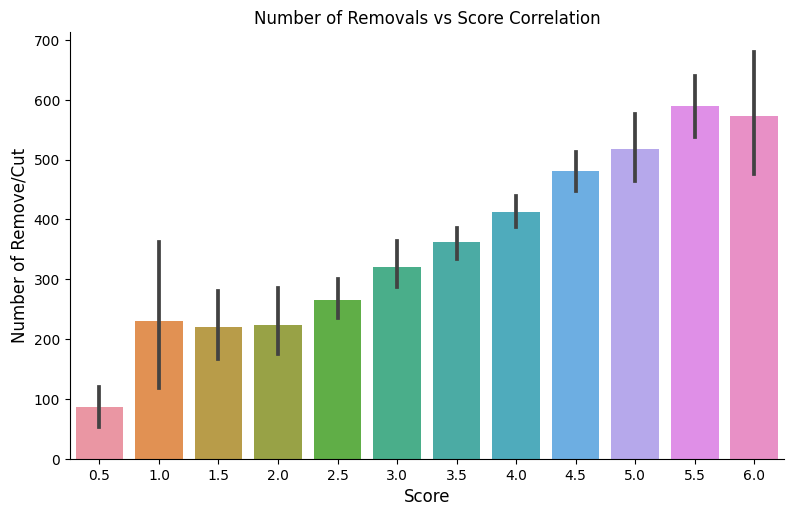

In [35]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Remove/Cut"].reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Remove/Cut', fontsize=12)
plt.title("Number of Removals vs Score Correlation")
plt.show()

#### Nonproduction

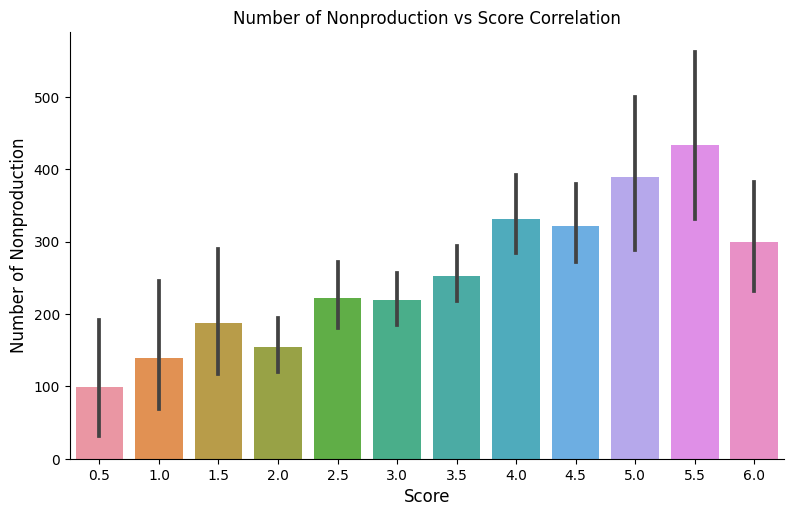

In [36]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Nonproduction"].reset_index()

stats_score = stats.merge(train_scores, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Nonproduction', fontsize=12)
plt.title("Number of Nonproduction vs Score Correlation")
plt.show()

#### Paste

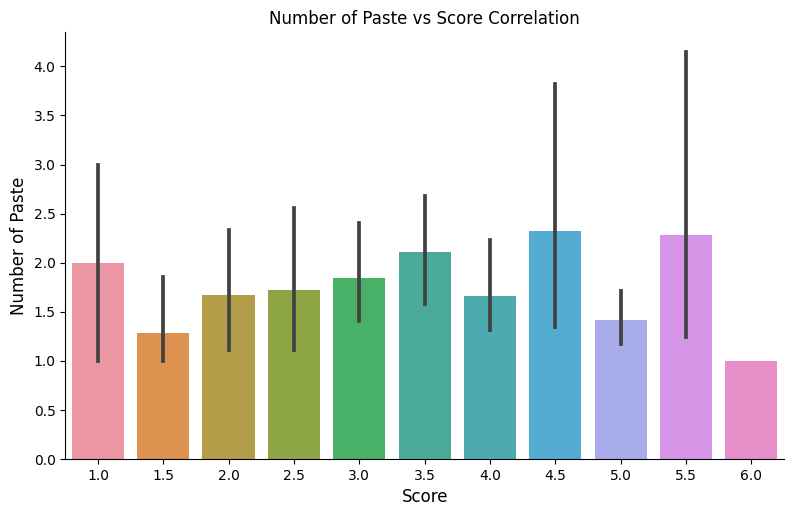

In [37]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Paste"].reset_index()

stats_score = stats.merge(train_scores, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Paste', fontsize=12)
plt.title("Number of Paste vs Score Correlation")
plt.show()

#### Replace

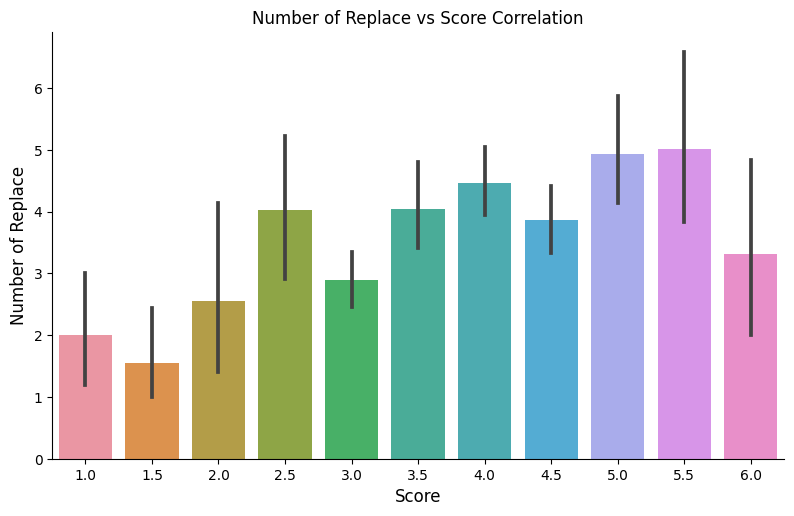

In [38]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Replace"].reset_index()

stats_score = stats.merge(train_scores, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Replace', fontsize=12)
plt.title("Number of Replace vs Score Correlation")
plt.show()

#### Replace + Paste

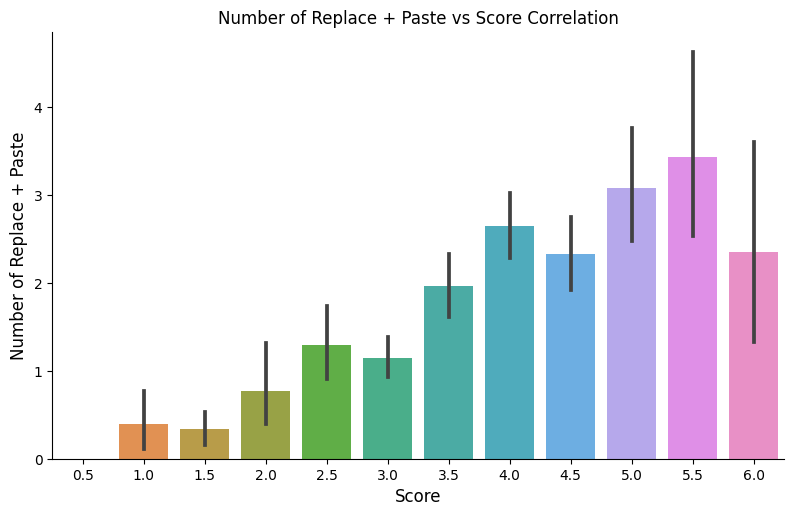

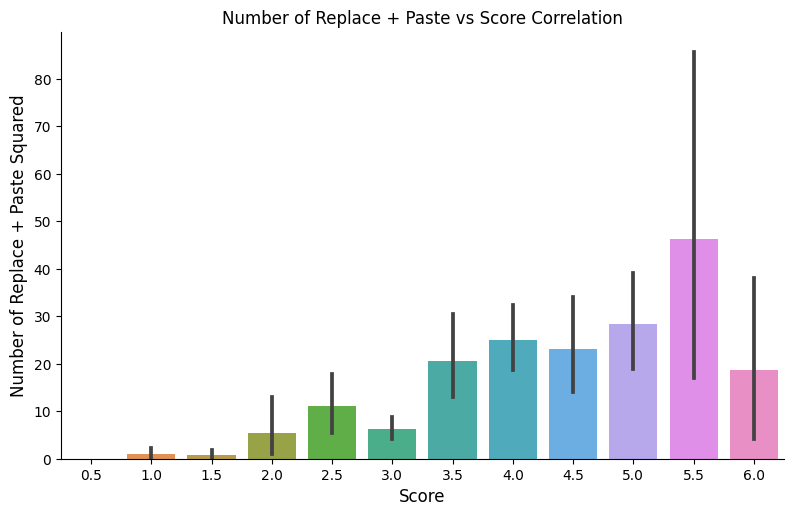

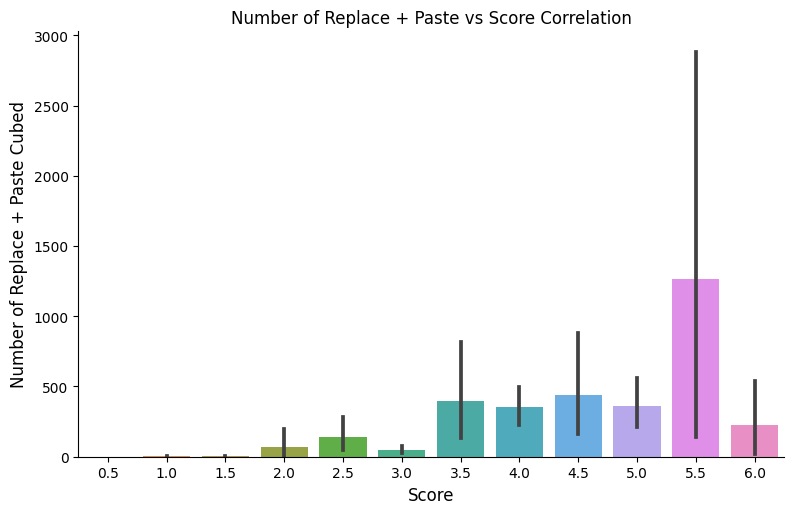

In [39]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
ids = np.unique(train_logs.id)
sums = np.zeros(len(ids))
sq = np.zeros(len(ids))
cubic = np.zeros(len(ids))

for index, id in enumerate(ids):
    sum = 0
    id_stats = stats[stats["id"] == id]

    if np.any(id_stats.activity == "Replace"):
        sum += float(id_stats[id_stats["activity"] == "Replace"]["count"].iloc[0])

    if np.any(id_stats.activity == "Paste"):
        sum += float(id_stats[id_stats["activity"] == "Paste"]["count"].iloc[0])
    
    # if np.any(id_stats.activity == "Input"):
    #     sum += float(id_stats[id_stats["activity"] == "Input"]["count"].iloc[0])
        
    sums[index] = sum
    sq[index] = sum * sum
    cubic[index] = sum * sum * sum

NewStats = pd.DataFrame({"id" : ids, "sum" : sums, "sq" : sq, "cubic" : cubic})
NewStats = NewStats.merge(train_scores, on="id")


sns.color_palette()
catplot = sns.catplot(data=NewStats, x="score", y="sum", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Replace + Paste', fontsize=12)
plt.title("Number of Replace + Paste vs Score Correlation")
plt.show()

catplot = sns.catplot(data=NewStats, x="score", y="sq", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Replace + Paste Squared', fontsize=12)
plt.title("Number of Replace + Paste vs Score Correlation")
plt.show()

catplot = sns.catplot(data=NewStats, x="score", y="cubic", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Replace + Paste Cubed', fontsize=12)
plt.title("Number of Replace + Paste vs Score Correlation")
plt.show()

#### Shifts

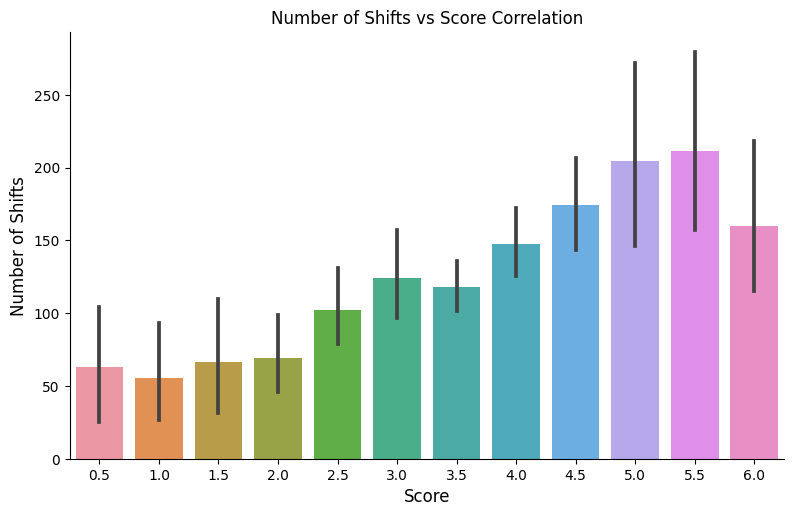

In [40]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"] == "Shift"].reset_index()
stats_score = stats.merge(train_scores, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Shifts', fontsize=12)
plt.title("Number of Shifts vs Score Correlation")
plt.show()

#### Puncuation

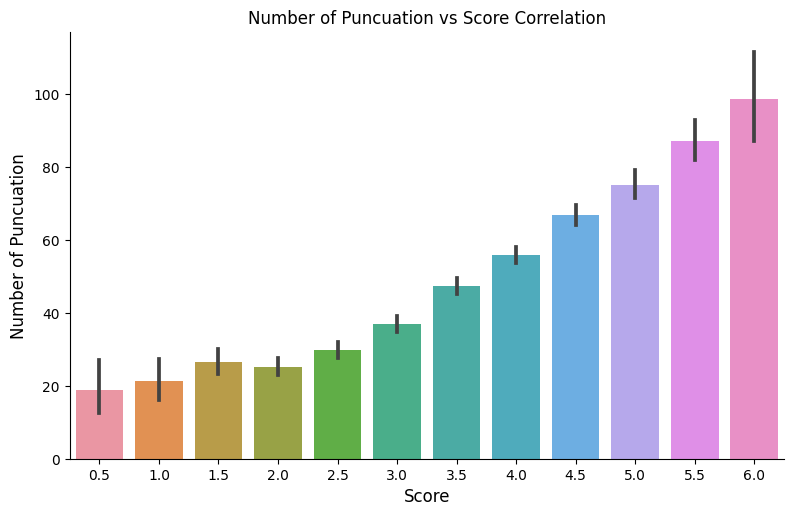

In [41]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"].isin(PUNCUATION)].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Puncuation', fontsize=12)
plt.title("Number of Puncuation vs Score Correlation")
plt.show()

#### Spaces + Caps Lock

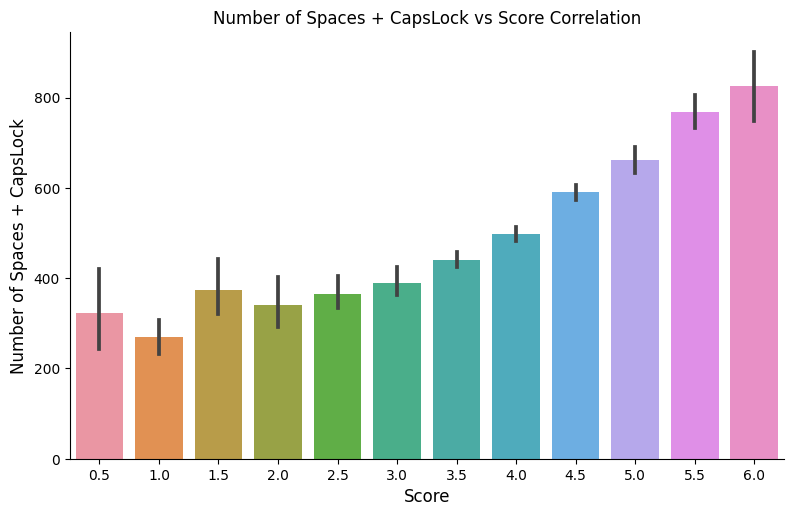

In [42]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"].isin(["Space", "CapsLock"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Spaces + CapsLock', fontsize=12)
plt.title("Number of Spaces + CapsLock vs Score Correlation")
plt.show()

#### Tabs + Spaces

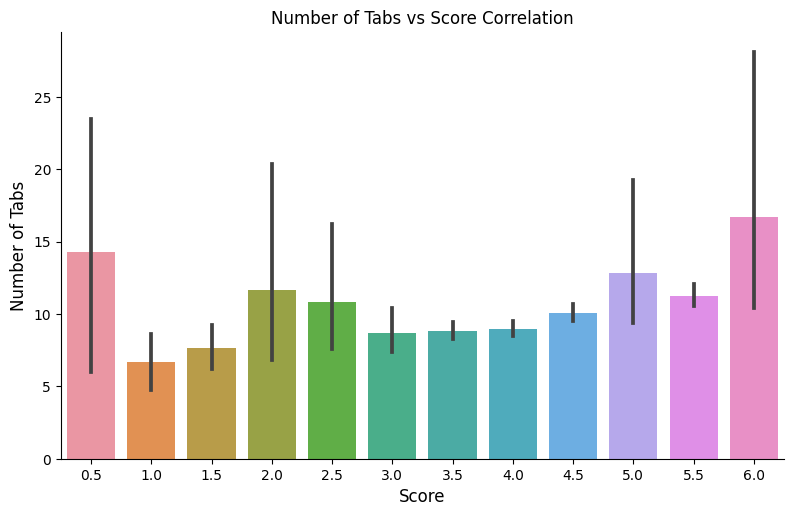

In [43]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"].isin(["Enter", "Tab"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Tabs', fontsize=12)
plt.title("Number of Tabs vs Score Correlation")
plt.show()

#### Movement

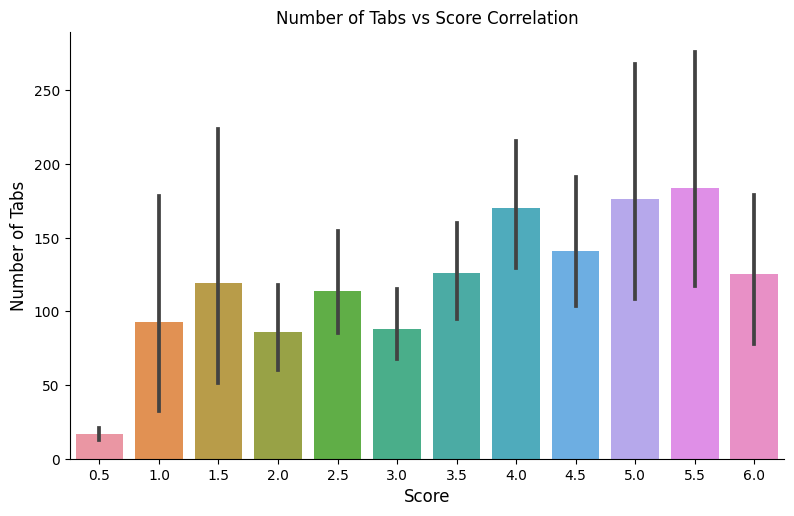

In [44]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"].isin(["Leftclick", "ArrowUp", "ArrowDown", "ArrowLeft", "ArrowRight"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Tabs', fontsize=12)
plt.title("Number of Tabs vs Score Correlation")
plt.show()

#### !?

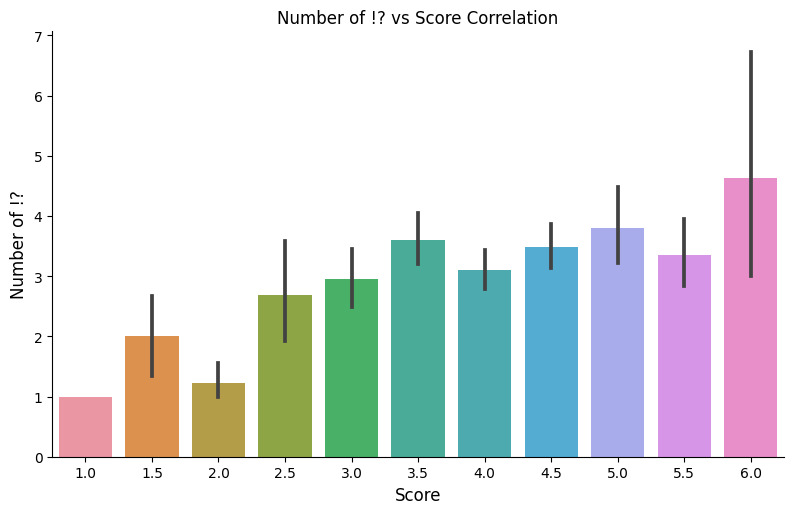

In [45]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"].isin(["!", "?"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of !?', fontsize=12)
plt.title("Number of !? vs Score Correlation")
plt.show()

#### Music

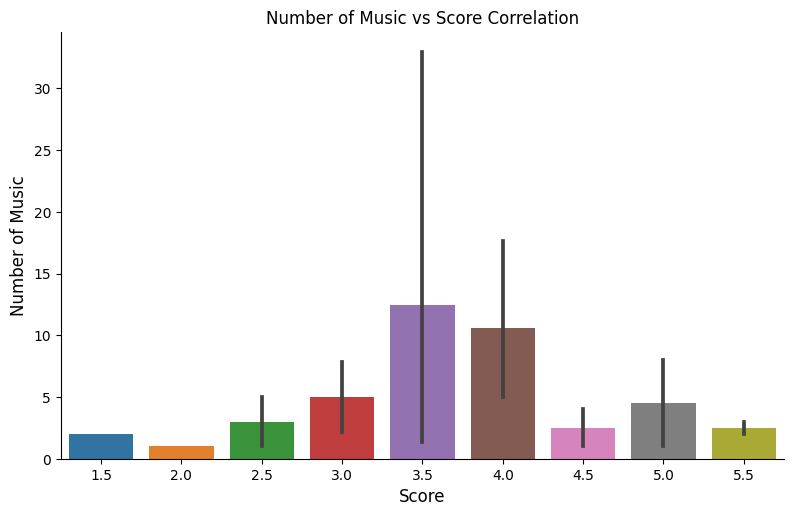

In [46]:
stats = train_logs.groupby("id")["down_event"].value_counts().reset_index()
stats = stats[stats["down_event"].isin(["AudioVolumeDown", "AudioVolumeMute", "AudioVolumeUp", "MediaPlayPause", "MediaTrackNext", "MediaTrackPrevious"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Music', fontsize=12)
plt.title("Number of Music vs Score Correlation")
plt.show()

### Text Change

#### q

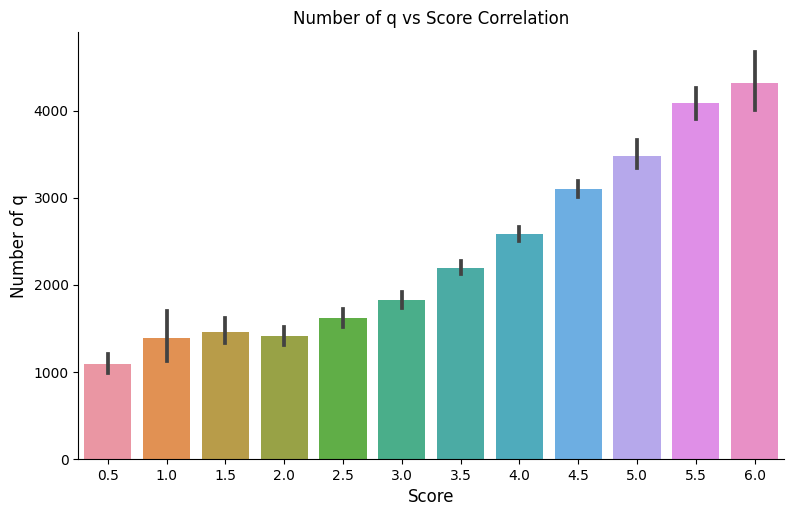

In [47]:
stats = train_logs.groupby("id")["text_change"].value_counts().reset_index()
stats = stats[stats["text_change"].isin(["q"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of q', fontsize=12)
plt.title("Number of q vs Score Correlation")
plt.show()

#### Whitespaces

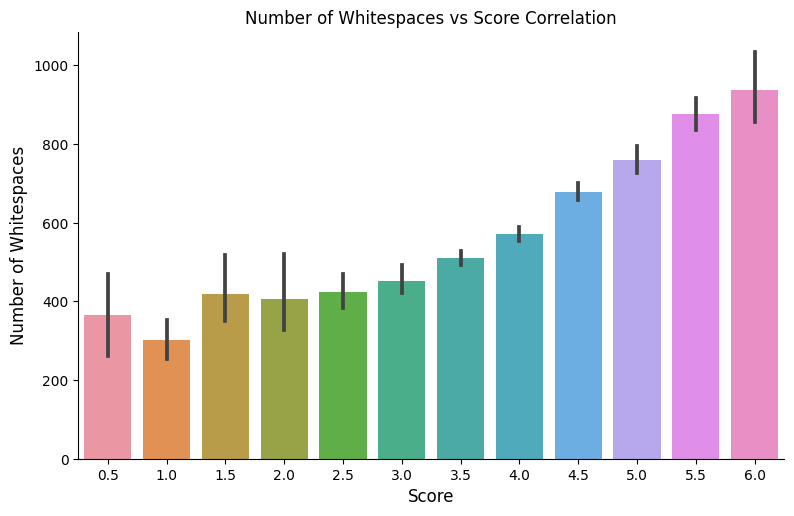

In [48]:
stats = train_logs.groupby("id")["text_change"].value_counts().reset_index()
stats = stats[stats["text_change"].isin([" ", "\n"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Whitespaces', fontsize=12)
plt.title("Number of Whitespaces vs Score Correlation")
plt.show()

#### No Change

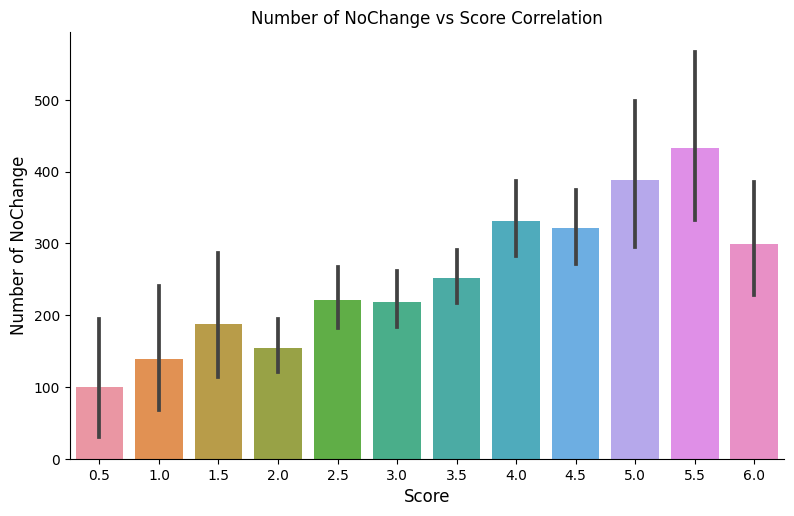

In [49]:
stats = train_logs.groupby("id")["text_change"].value_counts().reset_index()
stats = stats[stats["text_change"].isin(["NoChange"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of NoChange', fontsize=12)
plt.title("Number of NoChange vs Score Correlation")
plt.show()

#### q + Whitespace + NoChange

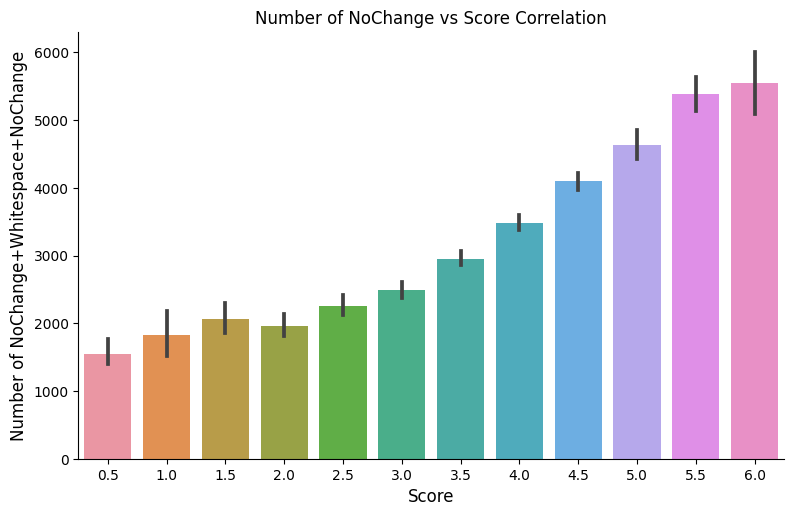

In [50]:
stats = train_logs.groupby("id")["text_change"].value_counts().reset_index()
stats = stats[stats["text_change"].isin(["NoChange", " ", "\n", "q"])].reset_index()
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of NoChange+Whitespace+NoChange', fontsize=12)
plt.title("Number of NoChange vs Score Correlation")
plt.show()

#### =>

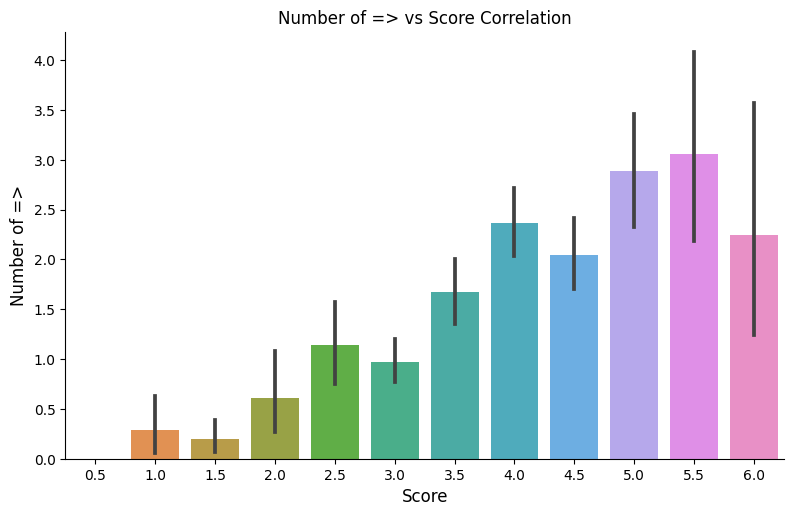

In [51]:
stats = train_logs.copy(deep=True)
stats["count"] = list(map(lambda x: x.count("=>"), stats['text_change']))
stats = stats.groupby("id")["count"].sum()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of =>', fontsize=12)
plt.title("Number of => vs Score Correlation")
plt.show()

## Essay Knitting

### Word Size

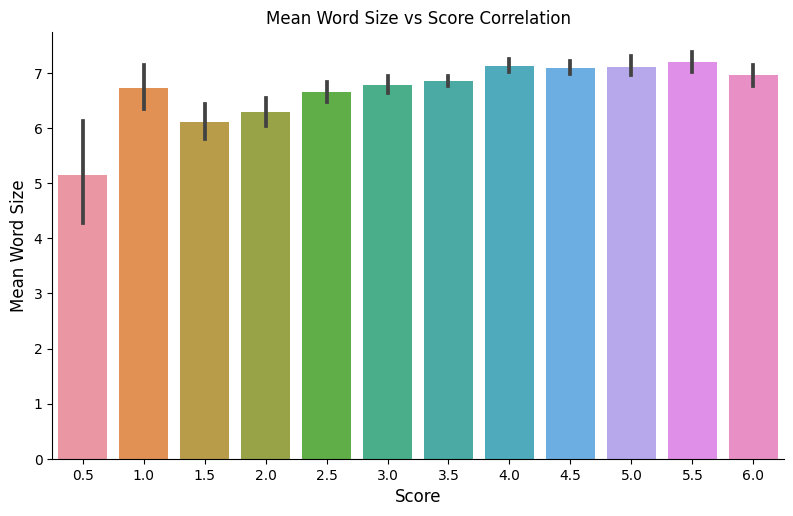

In [52]:
space_stats = train_logs[["id", "down_event", "event_id"]]
space_stats = space_stats[space_stats["down_event"].isin(["Space"])]
space_stats["word_size"] = space_stats.groupby("id")["event_id"].diff()
space_stats = space_stats.dropna(axis=0).reset_index()

stats = space_stats.groupby("id")["word_size"].mean().reset_index()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="word_size", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Mean Word Size', fontsize=12)
plt.title("Mean Word Size vs Score Correlation")
plt.show()

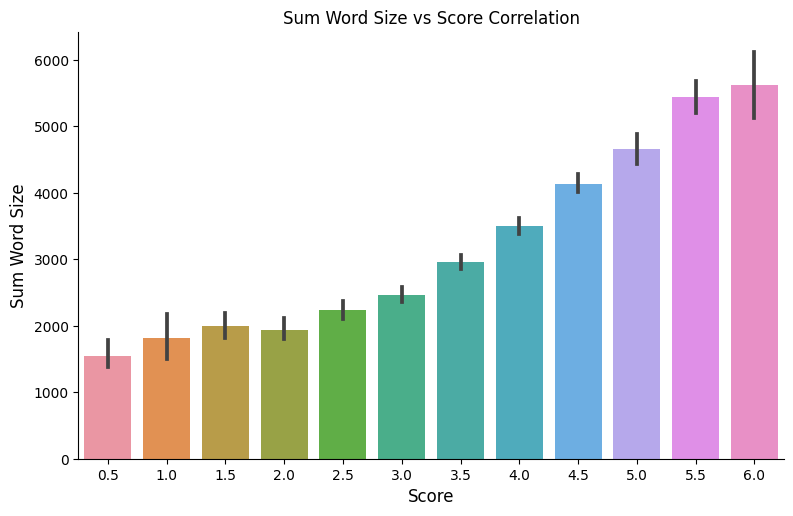

In [53]:
stats = space_stats.groupby("id")["word_size"].sum().reset_index()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="word_size", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Sum Word Size', fontsize=12)
plt.title("Sum Word Size vs Score Correlation")
plt.show()

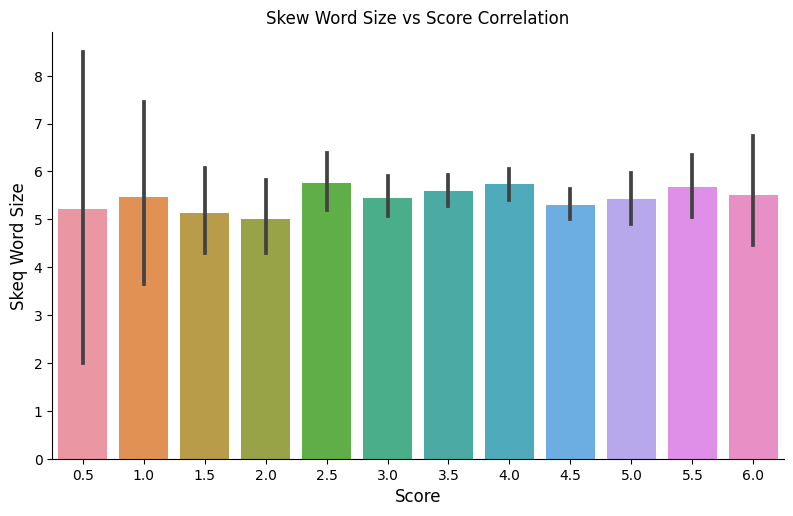

In [54]:
stats = space_stats.groupby("id")["word_size"].skew().reset_index()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="word_size", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Skeq Word Size', fontsize=12)
plt.title("Skew Word Size vs Score Correlation")
plt.show()

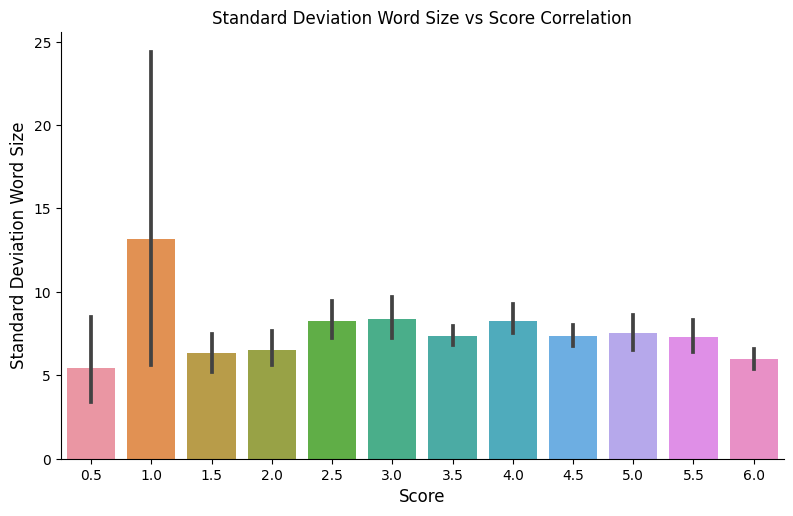

In [55]:
stats = space_stats.groupby("id")["word_size"].std().reset_index()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="word_size", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Standard Deviation Word Size', fontsize=12)
plt.title("Standard Deviation Word Size vs Score Correlation")
plt.show()

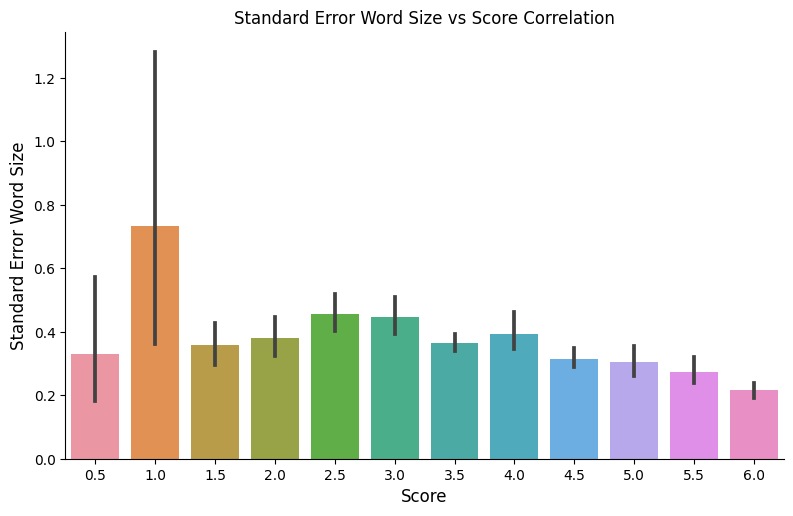

In [56]:
stats = space_stats.groupby("id")["word_size"].sem().reset_index()
stats_score = train_scores.merge(stats, on='id')

sns.color_palette()
catplot = sns.catplot(data=stats_score, x="score", y="word_size", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Standard Error Word Size', fontsize=12)
plt.title("Standard Error Word Size vs Score Correlation")
plt.show()

## Word Count vs Input Count

            id  word_count  index activity  count      ratio  score
0     001519c8         256      0    Input   2010   7.851562    3.5
1     0022f953         323      7    Input   1938   6.000000    3.5
2     0042269b         404     12    Input   3515   8.700495    6.0
3     0059420b         206     16    Input   1304   6.330097    2.0
4     0075873a         252     21    Input   1942   7.706349    4.0
...        ...         ...    ...      ...    ...        ...    ...
2466  ffb8c745         461   8848    Input   3588   7.783080    3.5
2467  ffbef7e5         438   8852    Input   2395   5.468037    4.0
2468  ffccd6fd         201   8856    Input   2849  14.174129    1.5
2469  ffec5b38         413   8859    Input   2895   7.009685    5.0
2470  fff05981         241   8862    Input   2452  10.174274    4.0

[2471 rows x 7 columns]


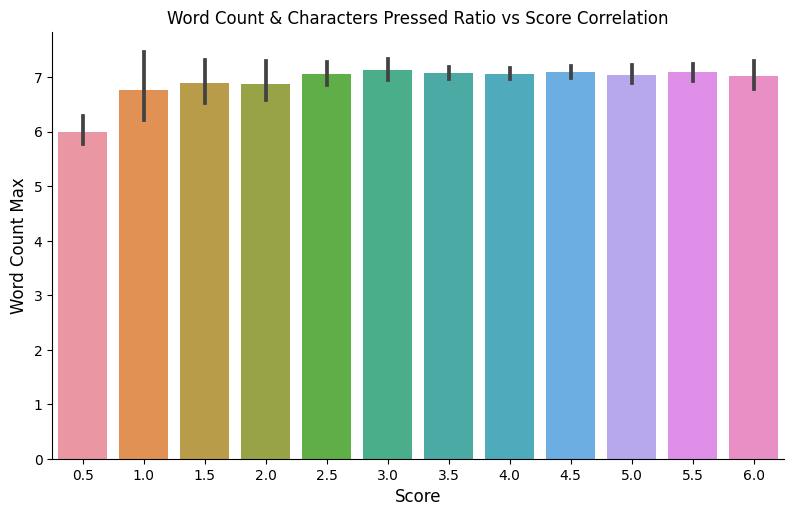

In [57]:
word_count = train_logs.groupby("id")["word_count"].max().reset_index()
input_count = train_logs.groupby("id")["activity"].value_counts().reset_index()
input_count = input_count[input_count["activity"] == "Input"].reset_index()
stats = word_count.merge(input_count, on='id')
stats["ratio"] = stats["count"] / stats["word_count"]
stats_score = stats.merge(train_scores, on='id')
print(stats_score)

catplot = sns.catplot(data=stats_score, x="score", y="ratio", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count Max', fontsize=12)
plt.title("Word Count & Characters Pressed Ratio vs Score Correlation")
plt.show()

## Word Count vs Max Cursor_Position

            id  word_count  cursor_position      ratio  score
0     001519c8         256             1539   6.011719    3.5
1     0022f953         323             1676   5.188854    3.5
2     0042269b         404             2291   5.670792    6.0
3     0059420b         206             1047   5.082524    2.0
4     0075873a         252             1402   5.563492    4.0
...        ...         ...              ...        ...    ...
2466  ffb8c745         461             1634   3.544469    3.5
2467  ffbef7e5         438             1877   4.285388    4.0
2468  ffccd6fd         201             2761  13.736318    1.5
2469  ffec5b38         413             2133   5.164649    5.0
2470  fff05981         241             1496   6.207469    4.0

[2471 rows x 5 columns]


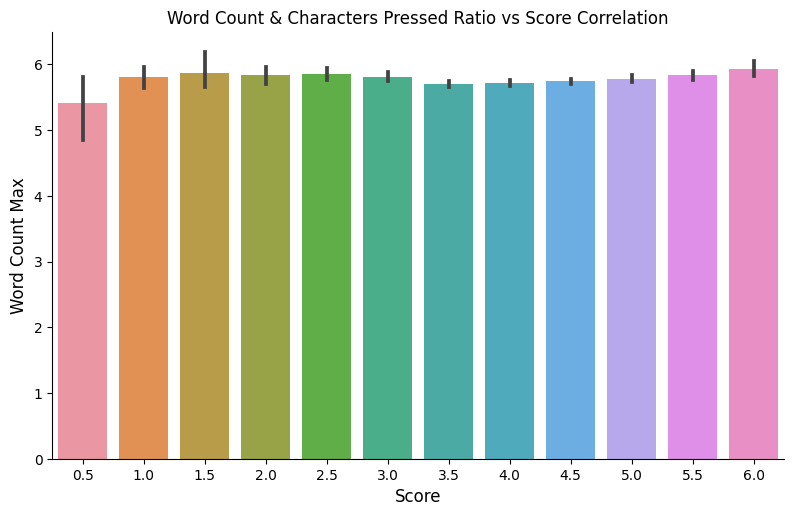

In [58]:
word_count = train_logs.groupby("id")["word_count"].max().reset_index()
character_count = train_logs.groupby("id")["cursor_position"].max().reset_index()
stats = word_count.merge(character_count, on='id')
stats["ratio"] = stats["cursor_position"] / stats["word_count"]
stats_score = stats.merge(train_scores, on='id')
print(stats_score)

catplot = sns.catplot(data=stats_score, x="score", y="ratio", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count Max', fontsize=12)
plt.title("Word Count & Characters Pressed Ratio vs Score Correlation")
plt.show()